<a href="https://colab.research.google.com/github/ellipticalcurves/aibjj/blob/main/Aibjj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 695.9/695.9 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 998.9/998.9 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.4 MB/s eta 0:00:00
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94506 sha256=f85451709849ee664bbeff085ccc2a9f562b60b4a8a5b1b8e315ae603504180

In [5]:
#@title Check if MuJoCo installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


NOTE: you may have to connect to a GPU instance of collab by changing run time type and selecting T4 GPU


In [6]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.0 MB/s eta 0:00:00


In [7]:
#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict


import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model


In [8]:
#@title 2_humanoids xml string

xml ="""<mujoco model="22 Humanoids">
  <option timestep="0.005"/>

  <size memory="100M"/>

  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="512" height="512"/>
    <texture name="body" type="cube" builtin="flat" mark="cross" width="128" height="128"
             rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" markrgb="1 1 1" random="0.01"/>
    <material name="body" texture="body" texuniform="true" rgba="0.8 0.6 .4 1"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>
  </asset>

  <default>
    <motor ctrlrange="-1 1" ctrllimited="true"/>
    <default class="body">

      <!-- geoms -->
      <geom type="capsule" condim="1" friction=".7" solimp=".9 .99 .003" solref=".015 1" material="body" group="1"/>
      <default class="thigh">
        <geom size=".06"/>
      </default>
      <default class="shin">
        <geom fromto="0 0 0 0 0 -.3"  size=".049"/>
      </default>
      <default class="foot">
        <geom size=".027"/>
        <default class="foot1">
          <geom fromto="-.07 -.01 0 .14 -.03 0"/>
        </default>
        <default class="foot2">
          <geom fromto="-.07 .01 0 .14  .03 0"/>
        </default>
      </default>
      <default class="arm_upper">
        <geom size=".04"/>
      </default>
      <default class="arm_lower">
        <geom size=".031"/>
      </default>
      <default class="hand">
        <geom type="sphere" size=".04"/>
      </default>

      <!-- joints -->
      <joint type="hinge" damping=".2" stiffness="1" armature=".01" limited="true" solimplimit="0 .99 .01"/>
      <default class="joint_big">
        <joint damping="5" stiffness="10"/>
        <default class="hip_x">
          <joint range="-30 10"/>
        </default>
        <default class="hip_z">
          <joint range="-60 35"/>
        </default>
        <default class="hip_y">
          <joint axis="0 1 0" range="-150 20"/>
        </default>
        <default class="joint_big_stiff">
          <joint stiffness="20"/>
        </default>
      </default>
      <default class="knee">
        <joint pos="0 0 .02" axis="0 -1 0" range="-160 2"/>
      </default>
      <default class="ankle">
        <joint range="-50 50"/>
        <default class="ankle_y">
          <joint pos="0 0 .08" axis="0 1 0" stiffness="6"/>
        </default>
        <default class="ankle_x">
          <joint pos="0 0 .04" stiffness="3"/>
        </default>
      </default>
      <default class="shoulder">
        <joint range="-85 60"/>
      </default>
      <default class="elbow">
        <joint range="-100 50" stiffness="0"/>
      </default>
    </default>
  </default>

  <visual>
    <map force="0.1" zfar="30"/>
    <rgba haze="0.15 0.25 0.35 1"/>
    <quality shadowsize="4096"/>
    <global offwidth="800" offheight="800"/>
  </visual>

  <worldbody>
    <geom name="floor" size="10 10 .05" type="plane" material="grid" condim="3"/>
    <light directional="true" diffuse=".4 .4 .4" specular="0.1 0.1 0.1" pos="0 0 5" dir="0 0 -1" castshadow="false"/>
    <light name="spotlight" mode="targetbodycom" target="world" diffuse="1 1 1" specular="0.3 0.3 0.3" pos="-6 -6 4" cutoff="60"/>
    <replicate count="2" euler="0 0 16.36" sep="-">
      <body name="torso" pos="-5 0 1.282" childclass="body">
        <camera name="back" pos="-3 0 1" xyaxes="0 -1 0 1 0 2" mode="trackcom"/>
        <camera name="side" pos="0 -3 1" xyaxes="1 0 0 0 1 2" mode="trackcom"/>
        <freejoint name="root"/>
        <geom name="torso" fromto="0 -.07 0 0 .07 0" size=".07"/>
        <geom name="waist_upper" fromto="-.01 -.06 -.12 -.01 .06 -.12" size=".06"/>
        <body name="head" pos="0 0 .19">
          <geom name="head" type="sphere" size=".09"/>
          <camera name="egocentric" pos=".09 0 0" xyaxes="0 -1 0 .1 0 1" fovy="80"/>
        </body>
        <body name="waist_lower" pos="-.01 0 -.26">
          <geom name="waist_lower" fromto="0 -.06 0 0 .06 0" size=".06"/>
          <joint name="abdomen_z" pos="0 0 .065" axis="0 0 1" range="-45 45" class="joint_big_stiff"/>
          <joint name="abdomen_y" pos="0 0 .065" axis="0 1 0" range="-75 30" class="joint_big"/>
          <body name="pelvis" pos="0 0 -.165">
            <joint name="abdomen_x" pos="0 0 .1" axis="1 0 0" range="-35 35" class="joint_big"/>
            <geom name="butt" fromto="-.02 -.07 0 -.02 .07 0" size=".09"/>
            <body name="thigh_right" pos="0 -.1 -.04">
              <joint name="hip_x_right" axis="1 0 0" class="hip_x"/>
              <joint name="hip_z_right" axis="0 0 1" class="hip_z"/>
              <joint name="hip_y_right" class="hip_y"/>
              <geom name="thigh_right" fromto="0 0 0 0 .01 -.34" class="thigh"/>
              <body name="shin_right" pos="0 .01 -.4">
                <joint name="knee_right" class="knee"/>
                <geom name="shin_right" class="shin"/>
                <body name="foot_right" pos="0 0 -.39">
                  <joint name="ankle_y_right" class="ankle_y"/>
                  <joint name="ankle_x_right" class="ankle_x" axis="1 0 .5"/>
                  <geom name="foot1_right" class="foot1"/>
                  <geom name="foot2_right" class="foot2"/>
                </body>
              </body>
            </body>
            <body name="thigh_left" pos="0 .1 -.04">
              <joint name="hip_x_left" axis="-1 0 0" class="hip_x"/>
              <joint name="hip_z_left" axis="0 0 -1" class="hip_z"/>
              <joint name="hip_y_left" class="hip_y"/>
              <geom name="thigh_left" fromto="0 0 0 0 -.01 -.34" class="thigh"/>
              <body name="shin_left" pos="0 -.01 -.4">
                <joint name="knee_left" class="knee"/>
                <geom name="shin_left" fromto="0 0 0 0 0 -.3" class="shin"/>
                <body name="foot_left" pos="0 0 -.39">
                  <joint name="ankle_y_left" class="ankle_y"/>
                  <joint name="ankle_x_left" class="ankle_x" axis="-1 0 -.5"/>
                  <geom name="foot1_left" class="foot1"/>
                  <geom name="foot2_left" class="foot2"/>
                </body>
              </body>
            </body>
          </body>
        </body>
        <body name="upper_arm_right" pos="0 -.17 .06">
          <joint name="shoulder1_right" axis="2 1 1"  class="shoulder"/>
          <joint name="shoulder2_right" axis="0 -1 1" class="shoulder"/>
          <geom name="upper_arm_right" fromto="0 0 0 .16 -.16 -.16" class="arm_upper"/>
          <body name="lower_arm_right" pos=".18 -.18 -.18">
            <joint name="elbow_right" axis="0 -1 1" class="elbow"/>
            <geom name="lower_arm_right" fromto=".01 .01 .01 .17 .17 .17" class="arm_lower"/>
            <body name="hand_right" pos=".18 .18 .18">
              <geom name="hand_right" zaxis="1 1 1" class="hand"/>
            </body>
          </body>
        </body>
        <body name="upper_arm_left" pos="0 .17 .06">
          <joint name="shoulder1_left" axis="-2 1 -1" class="shoulder"/>
          <joint name="shoulder2_left" axis="0 -1 -1"  class="shoulder"/>
          <geom name="upper_arm_left" fromto="0 0 0 .16 .16 -.16" class="arm_upper"/>
          <body name="lower_arm_left" pos=".18 .18 -.18">
            <joint name="elbow_left" axis="0 -1 -1" class="elbow"/>
            <geom name="lower_arm_left" fromto=".01 -.01 .01 .17 -.17 .17" class="arm_lower"/>
            <body name="hand_left" pos=".18 -.18 .18">
              <geom name="hand_left" zaxis="1 -1 1" class="hand"/>
            </body>
          </body>
        </body>
      </body>
    </replicate>
  </worldbody>

  <contact>
    <exclude body1="waist_lower" body2="thigh_right"/>
    <exclude body1="waist_lower" body2="thigh_left"/>
  </contact>

  <!--<tendon>
    <fixed name="hamstring_right" limited="true" range="-0.3 2">
      <joint joint="hip_y_right" coef=".5"/>
      <joint joint="knee_right" coef="-.5"/>
    </fixed>
    <fixed name="hamstring_left" limited="true" range="-0.3 2">
      <joint joint="hip_y_left" coef=".5"/>
      <joint joint="knee_left" coef="-.5"/>
    </fixed>
  </tendon> -->

  <actuator>
    <motor name="abdomen_z"       gear="40"  joint="abdomen_z"/>
    <motor name="abdomen_y"       gear="40"  joint="abdomen_y"/>
    <motor name="abdomen_x"       gear="40"  joint="abdomen_x"/>
    <motor name="hip_x_right"     gear="40"  joint="hip_x_right"/>
    <motor name="hip_z_right"     gear="40"  joint="hip_z_right"/>
    <motor name="hip_y_right"     gear="120" joint="hip_y_right"/>
    <motor name="knee_right"      gear="80"  joint="knee_right"/>
    <motor name="ankle_y_right"   gear="20"  joint="ankle_y_right"/>
    <motor name="ankle_x_right"   gear="20"  joint="ankle_x_right"/>
    <motor name="hip_x_left"      gear="40"  joint="hip_x_left"/>
    <motor name="hip_z_left"      gear="40"  joint="hip_z_left"/>
    <motor name="hip_y_left"      gear="120" joint="hip_y_left"/>
    <motor name="knee_left"       gear="80"  joint="knee_left"/>
    <motor name="ankle_y_left"    gear="20"  joint="ankle_y_left"/>
    <motor name="ankle_x_left"    gear="20"  joint="ankle_x_left"/>
    <motor name="shoulder1_right" gear="20"  joint="shoulder1_right"/>
    <motor name="shoulder2_right" gear="20"  joint="shoulder2_right"/>
    <motor name="elbow_right"     gear="40"  joint="elbow_right"/>
    <motor name="shoulder1_left"  gear="20"  joint="shoulder1_left"/>
    <motor name="shoulder2_left"  gear="20"  joint="shoulder2_left"/>
    <motor name="elbow_left"      gear="40"  joint="elbow_left"/>
  </actuator>
  <keyframe>
  <key qpos='-5 0 1.282 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -4.1204 0.0439149 1.2821 0.0357475 0.0169831 0.00416343 0.999208 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'/>
  <key qpos='-4.9369 0.0104954 0.877604 0.999617 0.0267022 0.00647118 -0.00319783 -0.0104185 -0.48433 -0.0602882 0.05204 -0.00947736 0.0303459 -2.28398 -0.202255 -0.095124 -0.0517436 0.0101542 0.045474 -2.28398 -0.196754 0.112707 0.10916 -0.0657979 -0.0187167 0.117478 -0.10947 0.00278909 -4.13095 0.0451804 1.27917 0.0337869 -0.0293599 0.00431884 0.998988 0.000878712 -0.0797496 -0.0055062 -0.0454015 0.00122102 -0.0133842 0.0420628 0.0748343 -0.0163969 -0.0123584 -0.000779432 -0.0139995 0.0429348 0.0763261 0.0147094 0.407914 -0.28512 -0.224151 0.410719 -0.277123 -0.221295'/>
  <key qpos='-4.9369 0.0104954 0.877604 0.999617 0.0267022 0.00647118 -0.00319783 -0.0104185 -0.420189 -0.0602882 -0.062854 -0.00947736 0.022719 -2.28398 -0.202255 -0.095124 -0.0517436 0.0101542 0.045474 -2.28398 -0.196754 0.112707 0.10916 -0.0657979 -0.0187167 0.117478 -0.10947 0.00278909 -4.39301 -0.0489197 0.970054 0.0329077 -0.0294438 0.0348755 0.998416 0.000878712 -1.309 -0.0055062 -0.279265 -1.047 -0.288826 -1.33663 0.0748343 -0.0163969 -0.5236 -1.047 0.185909 -1.11039 0.0763261 0.0147094 0.407914 -0.28512 -0.224151 0.410719 -0.277123 -0.221295'/>
  <key name="closed guard" qpos='-4.93912 0.00574695 0.781246 0.983692 0.00932319 0.174587 0.042218 -0.0116104 -0.827671 -0.028291 -0.0956173 -0.0029346 -0.0989541 -2.42802 0.0654537 0.0787425 -0.013588 0.0691285 -0.10043 -2.41905 0.0792197 0.0596308 0.173107 -0.229405 -0.508331 0.529554 -0.214771 -0.367333 -4.3503 -0.0448199 0.684852 0.0230275 0.0811853 0.00085943 0.996433 0.00598573 -1.12713 -0.0227058 -0.236974 -0.874702 -0.380878 -1.18933 0.206359 -0.142285 -0.429261 -0.885197 0.0282188 -0.832516 0.206467 -0.0937541 0.757062 -0.298457 -0.0624962 0.0231864 -0.458937 -0.568735'/>
  </keyframe>
</mujoco>"""

For some reason the keyframes are refusing to load from the xml so I made a helper function to load them up in the first frame instead. Here's the code I wanted to use since it's already in the package but for some reason its not picking up the keyframes in my xml file...

)`

```
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render()
```



In [12]:
def get_keyframe_pos(position):
  positions_dict = {"closed_guard":'-4.93912 0.00574695 0.781246 0.983692 0.00932319 0.174587 0.042218 -0.0116104 -0.827671 -0.028291 -0.0956173 -0.0029346 -0.0989541 -2.42802 0.0654537 0.0787425 -0.013588 0.0691285 -0.10043 -2.41905 0.0792197 0.0596308 0.173107 -0.229405 -0.508331 0.529554 -0.214771 -0.367333 -4.3503 -0.0448199 0.684852 0.0230275 0.0811853 0.00085943 0.996433 0.00598573 -1.12713 -0.0227058 -0.236974 -0.874702 -0.380878 -1.18933 0.206359 -0.142285 -0.429261 -0.885197 0.0282188 -0.832516 0.206467 -0.0937541 0.757062 -0.298457 -0.0624962 0.0231864 -0.458937 -0.568735',
                    "mount":'-0.3996 -0.000150175 0.0812943 0.722672 0.00260766 -0.691185 -0.000998103 0.00690147 -0.248907 -0.00909542 0.0517119 0.0425791 0.31546 0.0426445 -0.544643 -0.0800757 0.0234738 0.01933 0.301662 0.0424279 -0.434113 -0.0264994 0.145404 -0.730211 -1.7344 0.189468 -0.738147 -1.7283 0.0905397 0.0489033 0.745324 -0.230433 -0.0353762 0.156303 0.959801 0.147814 -0.449385 -0.497084 -0.530015 0.289257 0.28566 -2.25904 0.148578 0.111261 -0.51005 0.163537 -0.230121 -2.68457 -0.187291 -0.478854 0.280341 -0.456645 -1.75095 0.528194 0.0257501 -1.74844'
                    }
  position =  [float(x) for x in positions_dict[position].split()]
  return position

# strqpos00 = "-0.3996 -0.000150175 0.0812943 0.722672 0.00260766 -0.691185 -0.000998103 0.00690147 -0.248907 -0.00909542 0.0517119 0.0425791 0.31546 0.0426445 -0.544643 -0.0800757 0.0234738 0.01933 0.301662 0.0424279 -0.434113 -0.0264994 0.145404 -0.730211 -1.7344 0.189468 -0.738147 -1.7283 0.0905397 0.0489033 0.745324 -0.230433 -0.0353762 0.156303 0.959801 0.147814 -0.449385 -0.497084 -0.530015 0.289257 0.28566 -2.25904 0.148578 0.111261 -0.51005 0.163537 -0.230121 -2.68457 -0.187291 -0.478854 0.280341 -0.456645 -1.75095 0.528194 0.0257501 -1.74844"
# qpo0 = [float(x) for x in strqpos00.split()]
# data.qpos[:len(qpo0)] = qpo0

print(get_keyframe_pos("mount"))
qpo0 = get_keyframe_pos("closed_guard")

[-0.3996, -0.000150175, 0.0812943, 0.722672, 0.00260766, -0.691185, -0.000998103, 0.00690147, -0.248907, -0.00909542, 0.0517119, 0.0425791, 0.31546, 0.0426445, -0.544643, -0.0800757, 0.0234738, 0.01933, 0.301662, 0.0424279, -0.434113, -0.0264994, 0.145404, -0.730211, -1.7344, 0.189468, -0.738147, -1.7283, 0.0905397, 0.0489033, 0.745324, -0.230433, -0.0353762, 0.156303, 0.959801, 0.147814, -0.449385, -0.497084, -0.530015, 0.289257, 0.28566, -2.25904, 0.148578, 0.111261, -0.51005, 0.163537, -0.230121, -2.68457, -0.187291, -0.478854, 0.280341, -0.456645, -1.75095, 0.528194, 0.0257501, -1.74844]


""

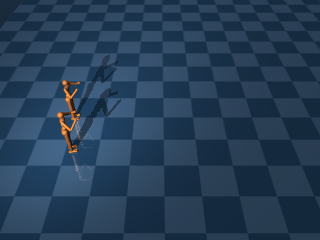

56


In [14]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())
mujoco.mj_resetDataKeyframe(model, data, 3)
print(len(data.qpos))

In [25]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Initialize to the standing-on-one-leg pose.
mujoco.mj_resetDataKeyframe(model, data, 1)
data.qpos[:len(qpo0)] = qpo0
frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

NOTE: This model is tendonless (I had to comment out the part where it says tendon because they still haven't implemented tendons...)

""

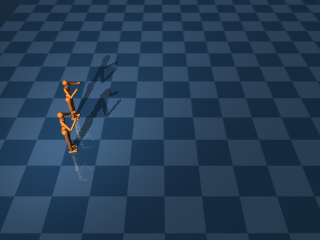

56


['-5', '0', '1.282', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '-4.1204', '0.0439149', '1.2821', '0.0357475', '0.0169831', '0.00416343', '0.999208', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
[-5.0, 0.0, 1.282, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.1204, 0.0439149, 1.2821, 0.0357475, 0.0169831, 0.00416343, 0.999208, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Main code starts from here


In [17]:
mj_model = mujoco.MjModel.from_xml_string(xml)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model)

In [18]:
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)
# print(mj_data.qpos, type(mj_data.qpos))
# print(mjx_data.qpos, type(mjx_data.qpos), mjx_data.qpos.devices())

In [ ]:
print(mj_model.nkey)
for key in range(mj_model.nkey):
  mujoco.mj_resetDataKeyframe(mj_model, mj_data, key)
  mujoco.mj_forward(mj_model, mj_data)
  renderer.update_scene(mj_data)
  media.show_image(renderer.render())

0


In [27]:
# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
#mujoco.mj_resetDataKeyframe(model, data, 1)

duration = 3.8  # (seconds)
framerate = 60  # (Hz)
mj_data.qpos[:len(qpo0)] = qpo0
frames = []


while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

StopIteration: 

In [43]:

jit_step = jax.jit(mjx.step)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mj_data.qpos[:len(qpo0)] = qpo0
mjx_data = mjx.put_data(mj_model, mj_data)
# Use the .at[] method for in-place updates in JAX arrays

print(mjx_data.qpos)
#mjx_data.qpos = qpo0
for i in range(len(mjx_data.qpos)):
  mjx_data.qpos.at[i].set(qpo0[i])

while mjx_data.time < duration:
  mjx_data = jit_step(mjx_model, mjx_data)
  if len(frames) < mjx_data.time * framerate:
    mj_data = mjx.get_data(mj_model, mjx_data)
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[-4.939  0.006  0.781  0.984  0.009  0.175  0.042 -0.012 -0.828 -0.028 -0.096 -0.003 -0.099 -2.428
  0.065  0.079 -0.014  0.069 -0.1   -2.419  0.079  0.06   0.173 -0.229 -0.508  0.53  -0.215 -0.367
 -4.35  -0.045  0.685  0.023  0.081  0.001  0.996  0.006 -1.127 -0.023 -0.237 -0.875 -0.381 -1.189
  0.206 -0.142 -0.429 -0.885  0.028 -0.833  0.206 -0.094  0.757 -0.298 -0.062  0.023 -0.459 -0.569]
